In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# فك الضغط

zip_path = "/content/drive/MyDrive/Sila Dataset/Mydata.zip"

In [3]:

# نفك الضغط داخل مجلد ثابت
!unzip -q "$zip_path" -d /content/dataset

In [4]:
# نتأكد إن المجلدات موجودة
!ls "/content/dataset/Mydata"

test  train  val


# ***Install and import***

In [22]:
# لو ما هو مثبّت
!pip -q install torch torchvision torchaudio scikit-learn

import os, json, time, math, random, shutil
from pathlib import Path
from glob import glob
import onnxruntime as ort


import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from PIL import Image

#عدلت لان CUDA  ما يشتغل على الماك

if torch.backends.mps.is_available():
    device = torch.device("mps")    # لو ماك (Apple Silicon)
elif torch.cuda.is_available():
    device = torch.device("cuda")   # لو ويندوز/لينكس و فيه  GPU
else:
    device = torch.device("cpu")    # fallback
print("Device:", device)
#تخلي الكود يشتغل بسرعة أعلى لو فيه هاردوير يدعم

Device: cuda


# ***Controls and Tracks***

In [6]:
# استخدم ناتج التقسيم/التوازن اللي سويته قبل شوي
SPLIT_SRC = Path("/content/dataset/Mydata")

IMG_SIZE   = 64
BATCH_SIZE = 128
EPOCHS     = 20
LR         = 1e-3
SEED       = 42

torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# نحدد الكلاسات من مجلد train تلقائيًا
classes = sorted([d.name for d in (SPLIT_SRC/"train").iterdir() if d.is_dir()])
num_classes = len(classes)      #يحسب عددها ويعمل قاموسين
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
print("Classes:", len(classes), classes[:10], "...")


Classes: 32 ['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain'] ...


# ***Simple data-loader for 64x64 grayscale images***

In [7]:
from PIL import Image

# يخزن قائمة الملفات مع لابلها، ومعرفة هل تطبق Augmentation ولا لا
class GrayFolderDataset(Dataset):
    def __init__(self, root: Path, class_to_idx: dict, aug=False):
        self.items = []
        self.class_to_idx = class_to_idx
        self.aug = aug

        # اجمع كل الصور تحت root/<class>/*.png
        for c in sorted(root.iterdir(), key=lambda p: p.name):
            if not c.is_dir():
                continue
            label = class_to_idx[c.name]
            for p in c.iterdir():
                if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}:
                    self.items.append((p, label))



        # تحويلات: رمادي → Tensor → Normalize
        base = [
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]

        # Augment بسيط للـtrain فقط (خفيف)
        # يقلل  overfitting
        if aug:
            augs = [
                transforms.RandomAffine(degrees=5, translate=(0.03,0.03)),
            ]
            self.tf = transforms.Compose(augs + base)
        else:
            self.tf = transforms.Compose(base)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("L")  # تأكيد رمادي
        img = self.tf(img)
        return img, label

train_ds = GrayFolderDataset(SPLIT_SRC/"train", class_to_idx, aug=True)
val_ds   = GrayFolderDataset(SPLIT_SRC/"val",   class_to_idx, aug=False)
test_ds  = GrayFolderDataset(SPLIT_SRC/"test",  class_to_idx, aug=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("sizes:", len(train_ds), len(val_ds), len(test_ds))  #يطبع أعداد العينات في كل مجموعة

sizes: 48038 4842 4842


In [9]:
!ls "/content/drive/MyDrive"
!ls "/content/drive/MyDrive/Sila Dataset"
!ls "/content/drive/MyDrive/Sila Dataset/models"

'Amirah Aldajani'	   'Amirah (Responses).gsheet'	    'Sila Dataset'
'Amirah aldajani (1).pdf'  'Colab Notebooks'		    'أميرة الدعجاني'
'Amirah aldajani.pdf'	   'E-commerce Management system '   تقديمي.gsheet
 Amirah.gform		    Sila
'AL (39).png'	  'FA (6).png'	    'KAAF (259).png'  'SAAD (746).png'
'Aleff (60).png'  'GHAIN (77).png'  'MEEM (206).png'  'THAL (823).png'
 dha.jpg	  'JEEM (213).png'   Mydata.zip        Zay.jpg
ls: cannot access '/content/drive/MyDrive/Sila Dataset/models': No such file or directory


# ***Light weight, accurate model for 64x64 grayscale photos***

In [16]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=32):
        super().__init__()
        # in: 1×64×64
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),     #الطبقة  الاولى
            nn.Conv2d(32,64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 64→32

            nn.Conv2d(64,128,3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),   # الطبقة الثانية
            nn.Conv2d(128,128,3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 32→16

            nn.Conv2d(128,256,3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),  # الطبقة الثالث
            nn.MaxPool2d(2),  # 16→8
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*8*8, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x

model = SmallCNN(num_classes=num_classes).to(device)  #ننشئ المودل وننقله للجهاز
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) # يحدّث أوزان المودل. lr يحدد الخطوة
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()
sum(p.numel() for p in model.parameters())/1e6

print("Model params (M):", round(sum(p.numel() for p in model.parameters())/1e6, 3))

Model params (M): 8.942


# ***Training with optimal weight retention and simple Early Stop***

In [17]:
from collections import deque

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in dl:
        xb, yb = xb.to(device, non_blocking=True), torch.tensor(yb).to(device)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        loss_sum += loss.item() * yb.size(0)
    return loss_sum/total, correct/total

best_val_acc = 0.0
patience, bad = 4, 0
best_path = Path("./models/best_sila_cnn.pt")
best_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(val_dl,   train=False)
    scheduler.step()

    print(f"Epoch {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad = 0
        torch.save({"model": model.state_dict(),
                    "classes": classes,
                    "img_size": IMG_SIZE}, best_path)
        print("  saved:", best_path)
    else:
        bad += 1
        if bad >= patience:
            print("Early stop")
            break

print("Best val acc:", best_val_acc)


/tmp/ipython-input-2941073268.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device, non_blocking=True), torch.tensor(yb).to(device)


Epoch 01/20 | train loss 3.1229 acc 0.1047 | val loss 2.5607 acc 0.2449
  saved: models/best_sila_cnn.pt
Epoch 02/20 | train loss 1.9535 acc 0.3430 | val loss 1.0848 acc 0.6675
  saved: models/best_sila_cnn.pt
Epoch 03/20 | train loss 1.5632 acc 0.4515 | val loss 0.8409 acc 0.7237
  saved: models/best_sila_cnn.pt
Epoch 04/20 | train loss 1.3693 acc 0.5152 | val loss 0.6308 acc 0.8067
  saved: models/best_sila_cnn.pt
Epoch 05/20 | train loss 1.2307 acc 0.5625 | val loss 0.4743 acc 0.8715
  saved: models/best_sila_cnn.pt
Epoch 06/20 | train loss 1.1346 acc 0.5960 | val loss 0.4305 acc 0.9000
  saved: models/best_sila_cnn.pt
Epoch 07/20 | train loss 1.0515 acc 0.6238 | val loss 0.3315 acc 0.9174
  saved: models/best_sila_cnn.pt
Epoch 08/20 | train loss 0.9992 acc 0.6423 | val loss 0.3267 acc 0.9362
  saved: models/best_sila_cnn.pt
Epoch 09/20 | train loss 0.9393 acc 0.6655 | val loss 0.2721 acc 0.9424
  saved: models/best_sila_cnn.pt
Epoch 10/20 | train loss 0.9002 acc 0.6786 | val loss 0

# ***Test evaluation and reports***

=== Final (TEST) Metrics ===
Accuracy : 0.9744
Precision: 0.9744  (macro)
Recall   : 0.9744  (macro)
F1-Score : 0.9743  (macro)

[Optional] Weighted Averages
Precision_w: 0.9746 | Recall_w: 0.9744 | F1_w: 0.9744

Per-class report:
              precision    recall  f1-score   support

         ain     0.9896    0.9896    0.9896       193
          al     0.9926    1.0000    0.9963       134
       aleff     0.9730    0.9730    0.9730       148
          bb     0.9938    0.9938    0.9938       161
         dal     0.9530    0.9793    0.9660       145
         dha     0.9675    0.9613    0.9644       155
        dhad     1.0000    0.9732    0.9864       149
          fa     0.9492    0.9545    0.9518       176
        gaaf     0.9527    0.9338    0.9431       151
       ghain     0.9778    0.9832    0.9805       179
          ha     0.9720    0.9789    0.9754       142
         haa     0.9416    0.9627    0.9520       134
        jeem     0.9362    0.9706    0.9531       136
        kaaf

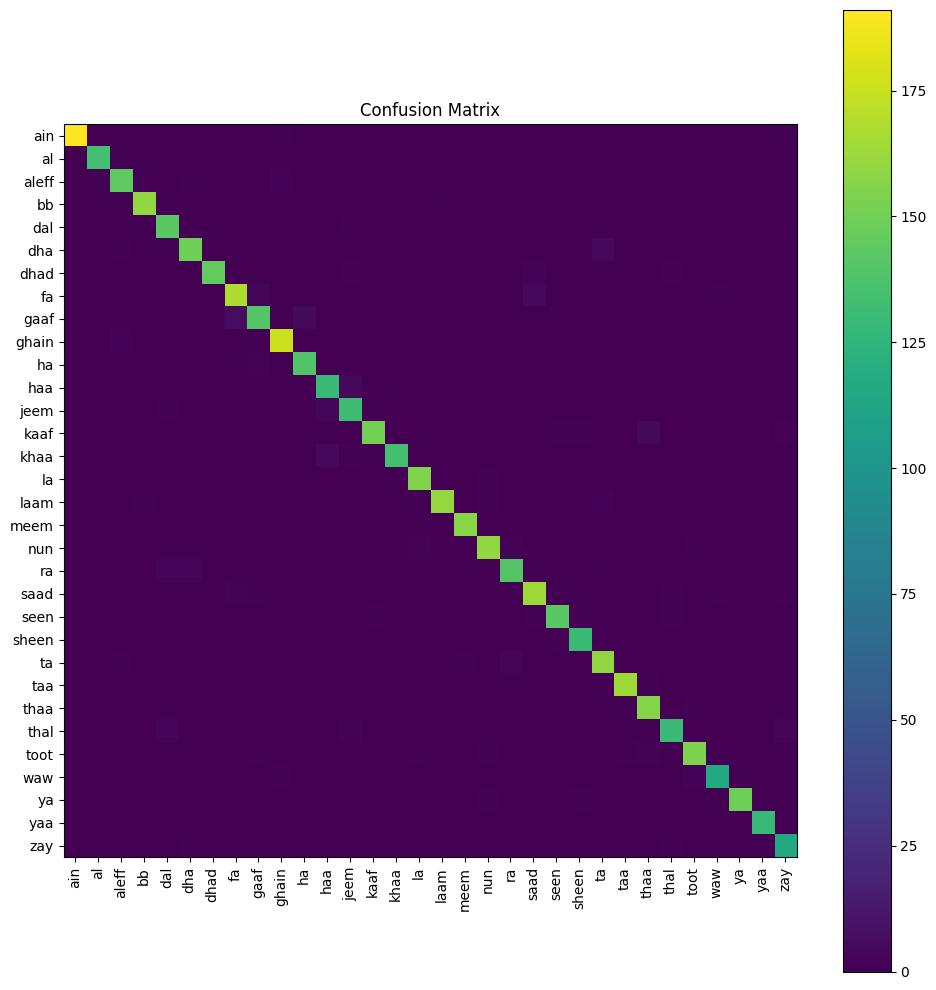

In [18]:
# [6] Evaluation — Accuracy / Precision / Recall / F1 + تقرير ومصفوفة التشتّت

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# حمّل أفضل وزن تم حفظه أثناء التدريب
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# مرّر على test_dl واجمع التنبؤات والملصقات الحقيقية
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy().tolist()   # أخذ أعلى احتمال
        all_preds.extend(preds)
        all_targets.extend(yb.numpy().tolist())

# --- المقاييس النهائية المطلوبة (Macro) ---
acc = accuracy_score(all_targets, all_preds)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="macro", zero_division=0
)

print("=== Final (TEST) Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec_macro:.4f}  (macro)")
print(f"Recall   : {rec_macro:.4f}  (macro)")
print(f"F1-Score : {f1_macro:.4f}  (macro)")

# (اختياري) لو تبي نسخة weighted أيضًا:
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="weighted", zero_division=0
)
print("\n[Optional] Weighted Averages")
print(f"Precision_w: {prec_w:.4f} | Recall_w: {rec_w:.4f} | F1_w: {f1_w:.4f}")

# تقرير تفصيلي لكل كلاس
print("\nPer-class report:")
print(classification_report(all_targets, all_preds, target_names=classes, digits=4, zero_division=0))

# مصفوفة التشتّت (Confusion Matrix)
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(num_classes), classes, rotation=90)
plt.yticks(range(num_classes), classes)
plt.tight_layout()
plt.show()

In [21]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


In [23]:
import torch

# أعد البناء والتحميل (من نفس الحفظ)
ckpt = torch.load(best_path, map_location="cpu")
classes = ckpt["classes"]

export_model = SmallCNN(num_classes=len(classes))
export_model.load_state_dict(ckpt["model"])
export_model.eval()

dummy = torch.randn(1, 1, 64, 64)  # نفس شكل الإدخال

onnx_path = "/content/model.onnx"
torch.onnx.export(
    export_model, dummy, onnx_path,
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13
)
print("Exported ONNX:", onnx_path)

# تنزيل على جهازك
from google.colab import files
files.download(onnx_path)

/tmp/ipython-input-2476787506.py:14: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Exported ONNX: /content/model.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Inference & Testing***
### هنا يطوال الاعمار ندرج صورة للمودل ونشوف نسبة الثقه انه يتعرف او لا او انه مودل يهبد لنا

In [ ]:
from PIL import Image

# دالة تتوقع على صورة واحدة
def predict_image(path: Path):
    # نفس التحويلات اللي استخدمناها وقت التدريب
    tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

    # اقرأ الصورة وحولها
    img = Image.open(path).convert("L")
    x = tf(img).unsqueeze(0).to(device)  # أضف بعد batch

    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred_idx = logits.argmax(1).item()
        prob = torch.softmax(logits, dim=1)[0, pred_idx].item()

    return idx_to_class[pred_idx], prob

# مثال: جرّب صورة من test set
sample_path = Path("/content/drive/MyDrive/Sila Dataset/SAAD (746).png")

pred_label, confidence = predict_image(sample_path)
print("Prediction:", pred_label, "| Confidence:", f"{confidence*100:.2f}%")
